# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> EE 046211 - Technion - Deep Learning
---

## Course Project - Know your trash
---

### <img src="https://img.icons8.com/bubbles/50/000000/information.png" style="height:50px;display:inline"> Students Information
---

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Alexander Balabanov| alexander.b@campus.technion.ac.il| 312775364|
|Dr. John Zoidberg| (\\\/)(;,,;)(\\\/)@campus.technion.ac.il| 3000|


### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Get Datasets
---
The project will include 2 dataset that we are going to work with:
- [COCO](https://cocodataset.org/#home), dataset of everyday images with 330k images and 80 catagories. The data is the segmantation of the objects.
- [TACO](http://tacodataset.org/), data of trash in nature 1500 images and 4784 instances.

Yolov5 is pretrained on COCO, pull from github
TACO can be downloaded from github as weel

In [ ]:
# Connect to drive to save work
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Clone yolo
%cd /content/gdrive/MyDrive/EEDL_046211/
!git clone https://github.com/ultralytics/yolov5
!git pull
%cd ./yolov5
%pip install -qr requirements.txt
%ls -l

In [ ]:
# Clone Taco
%cd /content/gdrive/MyDrive/EEDL_046211/
!git clone https://github.com/pedropro/TACO
!git pull
%cd ./TACO
%ls -l

In [ ]:
# Dowmload TACO dataset and split into train and test
%cd /content/gdrive/MyDrive/EEDL_046211/TACO/
!python3 download.py
%cd ./detector/
!python3 split_dataset.py -dataset_dir ../data/ --nr_trails 1

In [24]:
# imports for the tutorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import datetime
import glob
import time
import os
import csv
import json
import shutil

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms


%matplotlib inline

# Aux functions

In [25]:
%cd /content/gdrive/MyDrive/EEDL_046211/TACO/detector/

from utils import extract_bboxes
from dataset import Taco

def mkdir(dir_, dir):
  """Creeates directory if necessary and returns dir path"""
  d = os.path.join(dir_,dir)
  if not os.path.isdir(d):
    os.mkdir(d)
  return d


def get_class(i):
  """Stand in for future class dicts"""
  return int(i)


/content/gdrive/MyDrive/EEDL_046211/TACO/detector


# Create YOLO database

In [26]:
%cd /content/gdrive/MyDrive/EEDL_046211/TACO/detector/
#%rm -fr /content/gdrive/MyDrive/EEDL_046211/datasets/taco*

def yolo_dataset(cmap):
  """Get class map and creates a yolo format dataset
  dataset
   images
  |        train
  |       |        im1.jpg
  |       |        im2.jpg
  |       |        ...
  |       |        imN.jpg
  |
  |        val
  |       |        im1.jpg
  |       |        im2.jpg
  |       |        ...
  |       |        imN.jpg
   labels
  |        train
  |       |        im1.txt
  |       |        im2.txt
  |       |        ...
  |       |        imN.txt
  |
  |        val
  |       |        im1.txt
  |       |        im2.txt
  |       |        ...
  |       |        imN.txt
  """
  taco = 'taco_' + os.path.splitext(os.path.basename(cmap))[0]
  dir = '../../datasets'
  dir_tc = mkdir(dir, taco) # Directory for taco dataset in yolo format
  dir_im = mkdir(dir_tc, "images") # Images dir
  dir_lb = mkdir(dir_tc, "labels") # Labels dir

  class_map = cmap
  with open(class_map) as csvfile:
    reader = csv.reader(csvfile)
    class_map = {row[0]: row[1] for row in reader} #Class dictionary

  print(class_map)
  subsets = ["train", "val"]

  for subset in subsets: #Repeat for both datasets
    dir_im_ = mkdir(dir_im, subset)
    dir_lb_ = mkdir(dir_lb, subset)
    dataset = Taco() # Pulled from TACO github
    dataset.load_taco('../data/', 0, subset, class_map=class_map)
    dataset.prepare() # Dataset ready from .json file
    nrc = dataset.num_classes
    faulty = 0

    for idx in dataset._image_ids: # Go through all images in DS
      fn = dataset.image_info[idx]['path'] # image file name
      fn_im = os.path.dirname(fn).split('/')[-1] + "_" + os.path.basename(fn) # new name
      fn_lb = os.path.splitext(fn_im)[0] + ".txt" # label file name

      fn_im = os.path.join(dir_im_, fn_im) 
      fn_lb = os.path.join(dir_lb_, fn_lb)

      if not os.path.isfile(fn_im):
        shutil.copy(fn, fn_im) # Copy image to new location

      ms , cl = dataset.load_mask(idx) # TACO build in function gets mask and class
      bbox = extract_bboxes(ms) # Get's actual bounding box limits
      w_ , h_ = torch.tensor([dataset.image_info[idx]['width'] , dataset.image_info[idx]['height']]) #image width and height
      f = open(fn_lb, 'w')
      wr = csv.writer(f, delimiter= ' ') # New label text file to make the image

      for i in range(len(cl)):
        c = get_class(cl[i])-1
        y1, x1, y2, x2 = torch.Tensor(bbox[i]) # BBox come as edges
        #print(y1, x1, y2, x2)
        x = float((x1 + x2) / (2 * w_)) # Center x normalized [0-1]
        y = float((y1 + y2) / (2 * h_)) # Center y normalized [0-1]
        w = float((x2 - x1) / w_) # Width normalized [0-1]
        h = float((y2 - y1) / h_) # Height normalized [0-1]
        if (x<=1 and x>=0) and(y<=1 and y>=0) and(w<=1 and w>=0) and(h<=1 and h>=0) and (c >= 0 and c < nrc): # All in bounds
          wr.writerow([str(c)[:8], str(x)[:8], str(y)[:8], str(w)[:8], str(h)[:8]])
        else:
          faulty += 1 
      f.close()
    print("{} has {} faulty instances".format(fn, faulty))
#Yolo format : <class> <x-center> <y_center> <w> <h> normalized [0-1]
#COCO format : <class> <x-center> <y-center> <w> <h>

/content/gdrive/MyDrive/EEDL_046211/TACO/detector


In [ ]:
%cd /content/gdrive/MyDrive/EEDL_046211/TACO/detector/
yolo_dataset('./taco_config/map_17.csv') # Create dataset of 17 classes
yolo_dataset('./taco_config/map_10.csv') # Create dataset of 10 classes
yolo_dataset('./taco_config/map_4.csv') # Create dataset of 1 classes

# Get instances

In [27]:
%cd /content/gdrive/MyDrive/EEDL_046211/TACO/detector/
#%rm -fr ../../datasets/taco_classes*

def instances(cmap, dir_out, dir_lbl ,N=16, rep=4):
  """Sanity check function, make sure dataset is correct.
  Separate the datasets to instances and show them together"""
  print("Instances according to {}".format(cmap))
  dir_im = mkdir('./', dir_out) # Make dir for future instance images
  lbls = glob.glob(dir_lbl) # find all labels
  print("Found {} label files".format(len(lbls)))
  nr_classes= int(cmap.split('_')[1]) 
  cl_list = {c : [] for c in range(nr_classes)}
  # Create a dictionary in which each class is a list of all bboxes
  for lb in lbls:
    with open(lb, 'r') as f:
      for l in f.readlines():
        c , bbox = int(l.split()[0]), l.split()[1:]
        bbox = [float(x) for x in bbox]
        cl_list[c].append({'fn': lb, 'bb': torch.Tensor(bbox)})

  for cl in range(nr_classes):
    print("Class {} has {} instances".format(cl, len(cl_list[cl])))
    N = min(len(cl_list[cl]), N) # Bunch instances together
    if N > 0:
      shapes = torch.zeros(N, 3) # tally the shapes of alll instances
      if rep is None: # in this case repeat over all instances in list
        rep = len(cl_list[cl])
      for m in list(range(0, len(cl_list[cl]), N))[:rep]:
        imgs = []
        for j in range(N):
          fn , [x, y, w, h] = cl_list[cl][j+m]['fn'] , cl_list[cl][j+m]['bb'] #Get file name and bbox for said class
          fn_im = fn.replace('labels', 'images').replace('.txt', '.jpg') # Get image file name
          fn_im = fn_im if os.path.isfile(fn_im) else fn_im.replace('jpg', 'JPG') # For some reason it is necesary in this dataset
          img = torchvision.io.read_image(fn_im)
          img = torch.permute(img, (2, 1, 0)) # [C, H, W] ->[W, H, C]
          W, H = img.shape[:2]
          x1 = int((x - w / 2) * W) # pixle of top left x axis
          x2 = int((x + w / 2) * W) # pixle of bottom right x axis
          y1 = int((y - h / 2) * H) # pixle of top left y axis
          y2 = int((y + h / 2) * H) # pixle of bottom right y axis
          im = img[x1: x2 , y1: y2, :] # Crop to the instance alone
          imgs.append(im) # Add instance to instance list
          shapes[j] = torch.tensor([im.shape]) # Add shape of instances
        scale = int(torch.ceil(torch.sqrt(torch.Tensor([N])))) # Scaling the image to fit many instances in 1 image
        #print(torch.max(shapes, dim= 0))
        [w, h, c] = torch.max(shapes, dim= 0)[0]
        w, h = int(w) , int(h)
        col = torch.zeros((scale * w, scale * h, int(c)), dtype=torch.uint8) # big image to include all instances
        #print("col shape {}".format(col.shape))

        for j in range(scale):
          for k in range(scale):
            im = imgs[scale * j + k] 
            w_ , h_ = im.shape[:2]
            col[j*w: j*w + int(w_), k*h: k*h + int(h_),:] = im # Insert the instance in mega image
        fn_col = os.path.join(dir_im, "{}_b{}.jpg".format(cl, m))
        torchvision.io.write_jpeg(col.permute(2,1,0), fn_col)


/content/gdrive/MyDrive/EEDL_046211/TACO/detector


In [ ]:
%cd /content/gdrive/MyDrive/EEDL_046211/

instances("map_17", "./datasets/taco_classes_map_17", "./datasets/taco_map_17/labels/*/*.txt") # Check classes are correct
instances("map_10", "./datasets/taco_classes_map_10", "./datasets/taco_map_10/labels/*/*.txt")
instances("map_4", "./datasets/taco_classes_map_4", "./datasets/taco_map_4/labels/*/*.txt")
# The classes don't match their class number, manually check the images and write a correct yaml file

# Train Model

In [ ]:
%cd /content/gdrive/MyDrive/EEDL_046211/yolov5/
!python3 train.py --data ../taco_map_17.yaml --img 960 --batch 64 --epochs 200 --freeze 16 --project AD_map17_fz16 --cache --optimizer Adam --linear-lr

In [ ]:
%cd /content/gdrive/MyDrive/EEDL_046211/yolov5/
!python3 train.py --data ../taco_map_10.yaml --img 960 --batch 64 --epochs 200 --freeze 16 --project AD_map10_fz16 --cache --optimizer Adam --linear-lr

In [51]:
%cd /content/gdrive/MyDrive/EEDL_046211/yolov5/
!python3 train.py --data ../taco_map_4.yaml --img 480 --batch 256 --epochs 200  --freeze 23 --project AD_map4_fz23 --cache --optimizer Adam --linear-lr

/content/gdrive/MyDrive/EEDL_046211/yolov5
train: weights=yolov5s.pt, cfg=, data=../taco_map_4.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=200, batch_size=256, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=AD_map4_fz23, name=exp, exist_ok=False, quad=False, linear_lr=True, label_smoothing=0.0, patience=100, freeze=[23], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 12 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.0-197-g0cf932b torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1

# Eval

In [52]:
%cd /content/gdrive/MyDrive/EEDL_046211/yolov5/
!python3 val.py --data ../taco_map_4.yaml --img 480 --batch-size 256 --project AD_map4_fz23 --name val_map4 --weights ./AD_map4_fz23/exp/weights/best.pt

/content/gdrive/MyDrive/EEDL_046211/yolov5
val: data=../taco_map_4.yaml, weights=['./AD_map4_fz23/exp/weights/best.pt'], batch_size=256, imgsz=480, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=AD_map4_fz23, name=val_map4, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-197-g0cf932b torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '../datasets/taco_map_4/labels/val.cache' images and labels... 150 found, 0 missing, 0 empty, 0 corrupt: 100% 150/150 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:43<00:00, 43.90s/it]
                 all        150        528      0.542       0.21       0.24      0.153
              Bottle        150         49      0.713      0.3

# Deploy

In [53]:
%cd /content/gdrive/MyDrive/EEDL_046211/yolov5/
!python3 detect.py --source ../datasets/MyDataset --data ../taco_map_4.yaml  --img 480 --project AD_map4_fz23  --name run_map4  --weights ./AD_map4_fz23/exp/weights/best.pt  --save-txt

/content/gdrive/MyDrive/EEDL_046211/yolov5
detect: weights=['./AD_map4_fz23/exp/weights/best.pt'], source=../datasets/MyDataset, data=../taco_map_4.yaml, imgsz=[480, 480], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=AD_map4_fz23, name=run_map4, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-197-g0cf932b torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/28 /content/gdrive/MyDrive/EEDL_046211/datasets/MyDataset/IMG_20220124_105454_1.jpg: 480x256 1 Plastic, Done. (0.012s)
image 2/28 /content/gdrive/MyDrive/EEDL_046211/datasets/MyDataset/IMG_20220124_105500_1.jpg: 256x480 2 Others, Done. (0.012s)
image 3/28 /content/gdrive/MyDrive/EEDL_046211/dataset

# Histogram




In [45]:
def class_hist(path, names):
  cl_dct = {n:0 for n in names}
  for fn in glob.glob(path + "/*.txt"):
    f = open(fn, 'r')
    for r in f.readlines():
      cl = int(r.split()[0])
      cl_dct[names[cl]] = cl_dct.get(names[cl], 0) + 1
    f.close()
  fig = plt.figure(figsize=(8,8))
  plt.bar(list(cl_dct.keys()), list(cl_dct.values()))
  plt.xlabel("Type of trash")
  plt.ylabel("Quant")
  plt.title("Amount of trash according to each type")
  plt.show()

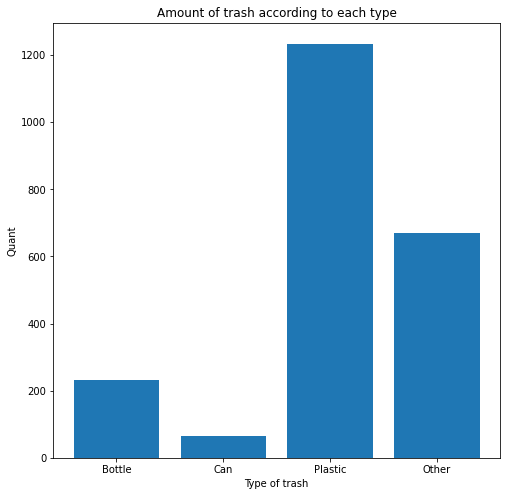

In [46]:
yaml = ['Bottle', 'Can', 'Plastic', 'Other']
class_hist('/content/gdrive/MyDrive/EEDL_046211/yolov5/AD_map4_fz20/run_map4/labels', yaml)

# My classes

In [28]:
%cd /content/gdrive/MyDrive/EEDL_046211/TACO/detector/

yolo_dataset('./taco_config/map_1.csv')
instances("map_1")

/content/gdrive/MyDrive/EEDL_046211/TACO/detector
{'Aerosol': 'Litter', 'Aluminium foil': 'Litter', 'Battery': 'Litter', 'Aluminium blister pack': 'Litter', 'Carded blister pack': 'Litter', 'Clear plastic bottle': 'Litter', 'Glass bottle': 'Litter', 'Other plastic bottle': 'Litter', 'Plastic bottle cap': 'Litter', 'Metal bottle cap': 'Litter', 'Broken glass': 'Litter', 'Drink can': 'Litter', 'Food Can': 'Litter', 'Corrugated carton': 'Litter', 'Drink carton': 'Litter', 'Egg carton': 'Litter', 'Meal carton': 'Litter', 'Other carton': 'Litter', 'Paper cup': 'Litter', 'Disposable plastic cup': 'Litter', 'Foam cup': 'Litter', 'Glass cup': 'Litter', 'Other plastic cup': 'Litter', 'Food waste': 'Litter', 'Plastic lid': 'Litter', 'Metal lid': 'Litter', 'Magazine paper': 'Litter', 'Tissues': 'Litter', 'Wrapping paper': 'Litter', 'Normal paper': 'Litter', 'Paper bag': 'Litter', 'Plastified paper bag': 'Litter', 'Pizza box': 'Litter', 'Garbage bag': 'Litter', 'Single-use carrier bag': 'Litter', 

In [47]:
%cd /content/gdrive/MyDrive/EEDL_046211/yolov5/
!python3 train.py --data ../taco_map_1.yaml --img 480 --batch 256 --epochs 200  --freeze 20 --project AD_map1_fz20 --cache --optimizer Adam --linear-lr

/content/gdrive/MyDrive/EEDL_046211/yolov5
train: weights=yolov5s.pt, cfg=, data=../taco_map_1.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=200, batch_size=256, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=AD_map1_fz20, name=exp, exist_ok=False, quad=False, linear_lr=True, label_smoothing=0.0, patience=100, freeze=[20], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 11 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.0-197-g0cf932b torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1

In [48]:
%cd /content/gdrive/MyDrive/EEDL_046211/yolov5/
!python3 val.py --data ../taco_map_1.yaml --img 480 --batch-size 64 --project AD_map1_fz20 --name val_map4 --weights ./AD_map1_fz20/exp/weights/best.pt

/content/gdrive/MyDrive/EEDL_046211/yolov5
val: data=../taco_map_1.yaml, weights=['./AD_map1_fz20/exp/weights/best.pt'], batch_size=64, imgsz=480, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=AD_map1_fz20, name=val_map4, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-197-g0cf932b torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '../datasets/taco_map_1/labels/val.cache' images and labels... 150 found, 0 missing, 0 empty, 0 corrupt: 100% 150/150 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00:24<00:00,  8.16s/it]
                 all        150        528      0.533      0.314      0.326      0.192
Speed: 0.1ms pre-process, 2.4ms inference, 2.2ms NMS per image 

In [49]:
%cd /content/gdrive/MyDrive/EEDL_046211/yolov5/
!python3 detect.py --source ../datasets/MyDataset --data ../taco_map_1.yaml  --img 960 --project AD_map1_fz20  --name run_map1  --weights ./AD_map1_fz20/exp/weights/best.pt  --save-txt

/content/gdrive/MyDrive/EEDL_046211/yolov5
detect: weights=['./AD_map1_fz20/exp/weights/best.pt'], source=../datasets/MyDataset, data=../taco_map_1.yaml, imgsz=[960, 960], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=AD_map1_fz20, name=run_map1, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-197-g0cf932b torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/27 /content/gdrive/MyDrive/EEDL_046211/datasets/MyDataset/IMG_20220124_105454_1.jpg: 960x480 11 Litters, Done. (0.012s)
image 2/27 /content/gdrive/MyDrive/EEDL_046211/datasets/MyDataset/IMG_20220124_105500_1.jpg: 480x960 5 Litters, Done. (0.017s)
image 3/27 /content/gdrive/MyDrive/EEDL_046211/datas

In [ ]:
%cd /content/gdrive/MyDrive/EEDL_046211/

patch_lbl = "./datasets/taco_classes_map_4_patch"
patch_blk = "./patches"

instances("map_4", patch_lbl, "./datasets/taco_map_4/labels/*/*.txt", N=1, rep=None)
instances("map_1", patch_blk, "./yolov5/AD_map1_fz20/run_map1/labels/*.txt", N=1, rep=None)

model = FairModel()
model.train_model(patch_lbl)
model.classify(patch_blk)

# Fair Model

  From testing we saw that the dataset isn't uniform, therefore we try to create a dataset that takes equalized labeled instances and trains on them, in testing will that the predicted instances of unlabeled litter and caterorices them.

Abandoned once seen that single class detection has too many false positive instances

In [ ]:
class FairModel(nn.Module):
  """CNN to distinguish litter instances to fitting class"""
  def __init__(self):
    super(FairModel, self).__init__(nr_classes)
    
    self.cnv = nn.Sequential([nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                               nn.BatchNorm2d(32),
                               nn.ReLU(inplace=True),
                               nn.MaxPool2d(kernel_size=2, stride=2), #16x16x32
                               nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                               nn.BatchNorm2d(64),
                               nn.ReLU(inplace=True),
                               nn.MaxPool2d(kernel_size=2, stride=2), #8x8x64
                               nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1), #4x4x64
                               nn.BatchNorm2d(64),
                               nn.ReLU(inplace=True),
                               nn.MaxPool2d(kernel_size=2, stride=2), #2x2x64
                               ])
    self.mlp = nn.Sequential([nn.Linear(256, 32),
                              nn.ReLU(inplace=True),
                              nn.Linear(32, nr_classes),
                              nn.Softmax()])
    

    
  def forward(ptchs):
    x = self.cnv(ptchs)
    c = self.mlp(x.view(x.shape[0], -1))
    return c


In [ ]:
class FairDataset(Dataset):
  def __init__(self, img_dir, transform=None, target_transform=None):
    super(Dataset, self).__init__()
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
    

  
  def __len__(self):
    return 0

  def __getitem__(self, idx):
    image = []
    bbox = []

    return image, bbox

# Usual suspects to train CNN

In [ ]:
def calculate_accuracy(model, dataloader, criterion, device):
    """Used on a set model to gain loss and accuracy, does not train"""
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    total_loss = 0
    with torch.no_grad():
        for data in dataloader: # Batch wise check
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # Run the images through the net
            _, predicted = torch.max(outputs.data, 1) # Top  result
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).data.item() / len(dataloader)

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, total_loss

In [ ]:
def train_model(model, path):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  criterion = nn.CrossEntropyLoss()
  optmizer = torch.optim.Adam(self.parameters(), lr=1e-3)
  schedule = torch.optim.lr_scheduler.LambdaLR(self.optm, 0.9)
  epochs = 128
  batch_sz = 64
  ds_trn = FairDataset(os.path.join(path, 'train'), transform=transf_train)
  ds_tst = FairDataset(os.path.join(path, 'test'), transform=transf_test)
  ld_trn = torch.utils.data.DataLoader(ds_trn, batch_size=batch_sz, shuffle=True)
  ld_tst = torch.utils.data.DataLoader(ds_tst, batch_size=batch_sz, shuffle=True)
  train_error = []
  test_error = []
  for epoch in range(1, epochs + 1):
      model.train()  # put in training mode
      running_loss = 0.0
      epoch_time = time.time()
      for i, data in enumerate(ld_trn, 0):
          # get the inputs
          inputs, labels = data
          # send them to device
          inputs = inputs.to(device)
          labels = labels.to(device)
          # forward + backward + optimize
          outputs = model.forward(inputs)  # forward pass
          loss = criterion(outputs, labels)  # calculate the loss
          # always the same 3 steps
          optimizer.zero_grad()  # zero the parameter gradients
          loss.backward()  # backpropagation
          optimizer.step()  # update parameters
          # Add statistics
          train_error.append(loss.data.item())
          running_loss += loss.data.item()
      # Advance in learning rate schedule
      # Normalizing the loss by the total number of train batches
      running_loss /= len(ld_trn)
      # Calculate training/test set accuracy of the existing model
      train_accuracy, _= calculate_accuracy(model, ld_trn, criterion, device)
      test_accuracy, test_loss = calculate_accuracy(model, ld_tst, criterion, device)
      test_error.append(test_loss)
      log = "Epoch: {:2d} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
      #train_error.append(running_loss)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)
  print('==> Finished Training ...')
  # Graph test and train loss across iterations
  batches = len(ld_trn)
  itr = list(range(epochs * batches))
  plt.plot(itr, train_error, 'r--', label='Train batch loss', linewidth=0.5)
  itr = list(range(batches,(epochs * len(ld_trn)+batches), batches))
  plt.plot(itr, test_error, color='g', label='Test Epoch loss', linewidth= 3)
  plt.title('Loss')
  plt.xlabel('Batch')
  plt.ylim(0, max(train_error))
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Grave yard

In [ ]:
!pip install optuna
# optuna
import optuna


In [ ]:
# Original class and bbox extractor fron JSON file
# JSON file had wrong data
%rm -fr ./datasets/taco
ann_j = "./TACO/data/annotations.json"
im_dir = "./TACO/data/"
new_dir = "./datasets/taco"
ds = json.load(open(ann_j, 'r'))
print(ds['images'][0].keys())
images = {x['id']: {'fn': x['file_name'], 'size': (x['width'], x['height'])} for x in ds['images']}
annots = [{'class' : x['category_id'], 'im_id': x['image_id'], 'bbox': x['bbox']} for x in ds['annotations']]

print("There are {} images and {} annotations".format(len(images), len(annots)))
print(annots[:3])
idx_train = sorted(np.random.choice(len(images), size=int(0.9*len(images)), replace=False))
idx_val = [x for x in range(len(images)) if x not in idx_train]

idx_type = [["train", idx_train], ['val', idx_val]]
os.mkdir(new_dir)
dir_im_ = os.path.join(new_dir, "images")
dir_lb_ = os.path.join(new_dir, "labels")
os.mkdir(dir_im_)
os.mkdir(dir_lb_)
for ds_type, idxs in idx_type:
  dir_im = os.path.join(dir_im_, ds_type)
  dir_lb = os.path.join(dir_lb_, ds_type)
  os.mkdir(dir_im)
  os.mkdir(dir_lb)  
  for idx in idx_train:
    fn_im = images[idx]['fn']
    fn_n_ = '_'.join(fn_im.split('/'))
    fn_n = os.path.join(dir_im, fn_n_)
    fn_o = os.path.join(im_dir, fn_im)

    shutil.copy(fn_o, fn_n)
    
    wd, hg = images[idx]['size']
    
    lbls = [x for x in annots if x['im_id'] == idx]
    fn_l = os.path.splitext(fn_n_)[0] + ".txt"
    fn_l = os.path.join(dir_lb, fn_l)
    f = open(fn_l, 'w')
    wr = csv.writer(f, delimiter= ' ')

    for l in lbls:
      r = [str(l['class']), 
           str(l['bbox'][0] / wd)[:8], 
           str(l['bbox'][1] / hg)[:8], 
           str(l['bbox'][2] / wd)[:8], 
           str(l['bbox'][3] / hg)[:8]]
      wr.writerow(r)
    f.close()



#Yolo format : <class> <x-center> <y_center> <w> <h> normalized [0-1]
#COCO format : <x-center> <y-center> <w> <h>

dict_keys(['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured', 'flickr_640_url'])
There are 1500 images and 4784 annotations
[{'class': 6, 'im_id': 0, 'bbox': [517.0, 127.0, 447.0, 1322.0]}, {'class': 18, 'im_id': 1, 'bbox': [1.0, 457.0, 1429.0, 1519.0]}, {'class': 14, 'im_id': 1, 'bbox': [531.0, 292.0, 1006.0, 672.0]}]


In [ ]:
def Taco_ds():
  reader = csv.reader(csv_file)
  class_map = {row[0]: row[1] for row in reader}
  map_to_one_class = {c: 'Litter' for c in class_map}
  dataset = "./TACO/data/"

  # Training dataset.
  dataset_train = Taco()
  dataset_train.load_taco(dataset, 1, "train", class_map=class_map, auto_download=None)
  dataset_train.prepare()
  nr_classes = dataset_train.num_classes
  # Validation dataset
  dataset_val = Taco()
  dataset_val.load_taco(dataset, 1, "val", class_map=class_map, auto_download=None)
  dataset_val.prepare()

  return dataset_train, dataset_val


tr, vl = Taco_ds()

class TACO_DataSet(Dataset):
  def __init__(self, img_dir, ann_j, class_map, transform=None, target_transform=None):
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
    ds = json.load(open(ann_j, 'r'))
  
  def __len__(self):
    return 0

  def __getitem__(self, idx):
    image = []
    bbox = []

    return image, bbox

creating index...
index created!
Number of images used: 1200
creating index...
index created!
Number of images used: 150


In [ ]:
class GIoU(nn.Module):
  def __init__(self):
    self.eq = 0

  def forward(pred, gt):
    return 0


def stepLrSch(opt):
  return torch.optim.lr_scheduler.StepLR(opt, 2, gamma=0.9)


def default_transform():
  return transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [ ]:
class HP():
  def __init__(self, name=None, epochs=16, btz=128, lr=1e-3, opt=None, crit=None, sch=None, bt_tr=None):
    self.name = datetime.datetime.now().strftime("%Y-%m-%d--%H,%M")
    self.epochs = epochs
    self.batch_size = btz
    self.lr = lr
    self.optimizer = opt if opt is not None else torch.optim.Adam
    self.criterion = crit if crit is not None else GIou()
    self.scheduler = sch if sch is not None else stepLrSch
    self.bt_transform = bt_tr if bt_tr is not None else default_transform()
  
  def get_optimizer(model):
    self.optimizer = self.optimizer(model.parameters(), lr=self.lr)
    return self.optimizer

  def get_criterion():
    return self.criterion

  def get_scheduler():
    self.scheduler = self.scheduler(self.optimizer)
    return self.scheduler

  def export():
    return None


In [ ]:
def TACO_model(classes=25, freeze=1):  
  yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True, classes=classes)
  for m in [m_ for m_ in yolo.modules()][:-freeze]:
    m.requires_grad_(False)
  return yolo


In [ ]:
class DL_model():
  def __init__(self, hp=None):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.model = TACO_model().to(self.device)
    self.hp = hp if hp is not None else HP()
    self.optimizer = hp.get_optimizer(self.model)
    self.criterion = hp.get_criterion()
    self.scheduler = hp.get_scheduler()

  def evaluate():
    return 0.0

  def train():
    return None

In [ ]:
# Working with model from pytorch wasn't as managable as train python script
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [ ]:
dir = 'https://ultralytics.com/images/'
imgs = [dir + f for f in ('zidane.jpg', 'bus.jpg')]  # batch of images

# Inference
results = model(imgs)
results.print()  # or .show(), .save()
results.pandas().xyxy[1]